<a href="https://colab.research.google.com/github/manu68-debugs/Retina-Image-segmentation/blob/main/UNET_RETINA_FRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abdallahwagih/retina-blood-vessel
!unzip -q retina-blood-vessel.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel
License(s): apache-2.0
retina-blood-vessel.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/Data/test/image/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
    def __getitem__(self, index):
        # Reading image
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        # Reading mask
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [ ]:
# Build Conv_layer
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [ ]:
# Build Encoder section
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [ ]:
# Build Decoder section
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [ ]:
# Build Unet architecture
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [ ]:
# Dice Coefficient
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

       # label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
# Dice Binary Cross Entropy Coefficient
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [ ]:
# Seeding
seeding(42)

create_dir("files")
train_x = sorted(glob("/content/dataset/Data/train/image/*"))
train_y = sorted(glob("/content/dataset/Data/train/mask/*"))
valid_x = sorted(glob("/content/dataset/Data/test/image/*"))
valid_y = sorted(glob("/content/dataset/Data/test/mask/*"))
data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



In [ ]:
H = 512
W = 512
size = (H, W)
batch_size = 2
lr = 1e-4
checkpoint_path = "files/checkpoint.pth"

In [ ]:
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [ ]:
# Set cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model = build_unet()
model = model.to(device)

# Set Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [ ]:
best_valid_loss = float("inf")
num_epochs = 5
start_epoch = 0  # Set this manually if resuming

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    # Saving the full checkpoint
    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

        best_valid_loss = valid_loss

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_valid_loss': best_valid_loss
        }, checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\tVal. Loss: {valid_loss:.3f}\n'
    print(data_str)


Valid loss improved from inf to 1.3457. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 43m 5s
	Train Loss: 1.267
	Val. Loss: 1.346

Valid loss improved from 1.3457 to 1.0163. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 42m 49s
	Train Loss: 1.062
	Val. Loss: 1.016

Valid loss improved from 1.0163 to 0.9405. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 42m 45s
	Train Loss: 0.990
	Val. Loss: 0.941

Valid loss improved from 0.9405 to 0.9059. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 43m 23s
	Train Loss: 0.944
	Val. Loss: 0.906

Valid loss improved from 0.9059 to 0.8898. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 43m 55s
	Train Loss: 0.901
	Val. Loss: 0.890



In [ ]:
def calculate_metrics(y_true, y_pred):
    # Ground truth
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    # Prediction
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [ ]:
#  Seeding
seeding(42)
create_dir("results")

# Load dataset
test_x = sorted(glob("/content/dataset/Data/test/image/*"))
test_y = sorted(glob("/content/dataset/Data/test/mask/*"))

In [ ]:
checkpoint_path = "/content/files/checkpoint.pth"

# Load full checkpoint (not just state_dict)
checkpoint = torch.load(checkpoint_path, map_location=device)

# Initialize model
model = build_unet()
model.load_state_dict(checkpoint['model_state_dict'])  # Load just the weights
model.to(device)
model.eval()


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [ ]:
!file /content/files/checkpoint.pth


/content/files/checkpoint.pth: Zip archive data, at least v0.0 to extract, compression method=store


In [ ]:
metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    # Extract the name
    name = x.split("/")[-1].split(".")[0]
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    # Reading mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y / 255.0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
        # Prediction and Calculating FPS
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)


        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    # Saving masks
    ori_mask = mask_parse(mask)
    pred_y = mask_parse(pred_y)
    line = np.ones((size[1], 10, 3)) * 128

    cat_images = np.concatenate(
        [image, line, ori_mask, line, pred_y * 255], axis=1
    )
    cv2.imwrite(f"results/{name}.png", cat_images)

100%|██████████| 20/20 [03:21<00:00, 10.06s/it]


In [ ]:
jaccard = metrics_score[0] / len(test_x)
f1 = metrics_score[1] / len(test_x)
recall = metrics_score[2] / len(test_x)
precision = metrics_score[3] / len(test_x)
acc = metrics_score[4] / len(test_x)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

Jaccard: 0.5810 - F1: 0.7338 - Recall: 0.8579 - Precision: 0.6508 - Acc: 0.9454
FPS:  0.10131147082364186


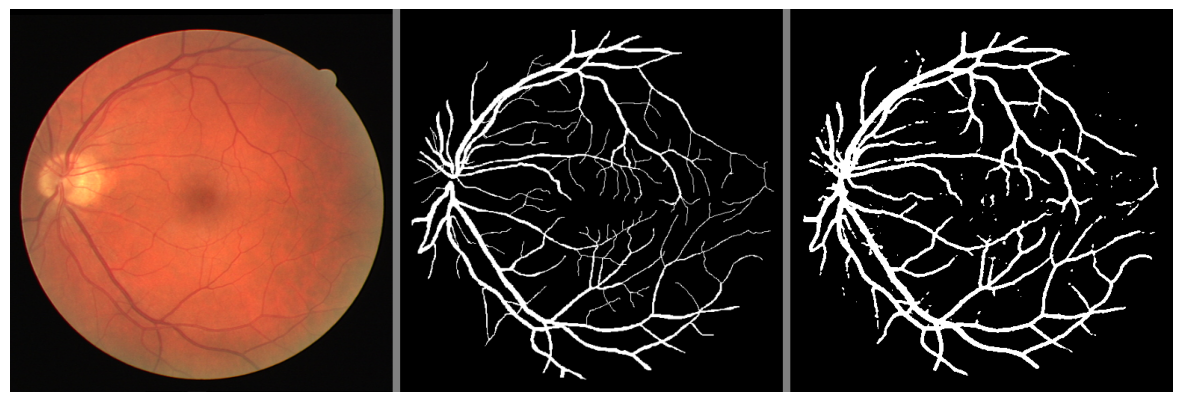

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('/content/results/11.png')
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.axis('off')

plt.show()


In [ ]:
from google.colab import files
files.download('/content/files/checkpoint.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>